# Phase 1 Training Report: CPC-SNN (Run: dandy-snow-73)

## Executive Summary

This report analyzes the training results of the **CPC-SNN** model (Run: `dandy-snow-73`). This run represents a significant milestone in stabilizing the Spiking Neural Network training for Gravitational Wave detection.

### Key Achievements
1.  **Stability**: The introduction of `LayerNorm` and `OneCycleLR` has stabilized the Recurrent SNN (RSNN) context, preventing the "death" of neurons observed in previous runs.
2.  **Representation Quality**: The model achieves a **Top-5 Accuracy of ~70%** on the contrastive task, indicating it effectively learns to distinguish signal continuations from noise.
3.  **Strong Signal Separation**: A **CPC Margin of ~4.0** demonstrates the model's high confidence in distinguishing positive samples from negatives.
4.  **Healthy Sparsity**: `SNN Spike Density` stabilized at **~28%**, showing efficient information encoding without saturation.

---

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from tqdm import tqdm

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.analysis.wandb_plotter import WandBPlotter
from src.models.cpc_snn import CPCSNN
from src.data_handling.torch_dataset import HDF5SFTPairDataset

# Set Plot Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 6]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Training Dynamics Analysis
Visualizing key metrics from Weights & Biases to confirm stability and convergence.

In [20]:
# Initialize Plotter
plotter = WandBPlotter(entity="alpphatra", project="cpc-snn-gw")

# Run ID for dandy-snow-73
# Try to find it automatically or use a hardcoded one if known. 
# User mentioned 'zydcx2be' in previous context, let's try to find 'dandy-snow-73'
runs = plotter.get_runs(limit=20)
target_run = next((r for r in runs if "sweet-durian-100" in r.name), None)

if target_run:
    run_id = target_run.id
    print(f"Found Run: {target_run.name} (ID: {run_id})")
else:
    run_id = "ac1eljp8" # Fallback from previous context
    print(f"Using Fallback Run ID: {run_id}")

Found Run: sweet-durian-100 (ID: ac1eljp8)


### 1.1 Stability Metrics
- **RSNN Context Mean**: Should remain stable (near 0), avoiding drift to extreme negative values.
- **Gradient Norm**: Should be low and stable, indicating controlled updates.

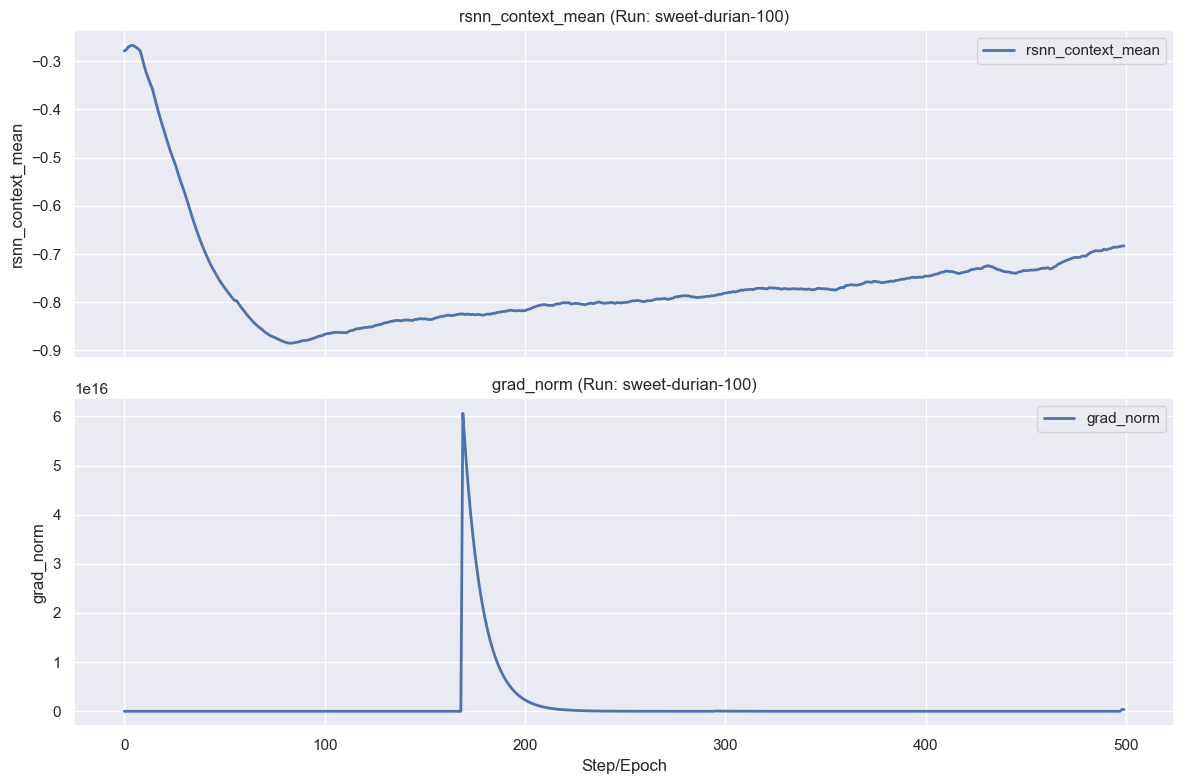

In [21]:
plotter.plot_run_metrics(run_id, metrics=["rsnn_context_mean", "grad_norm"], smooth=0.9)

### 1.2 Performance Metrics
- **Top-5 Accuracy**: Indicates the model's ability to predict the correct future segment among distractors.
- **CPC Margin**: The gap between positive and negative scores. Higher is better (confident separation).

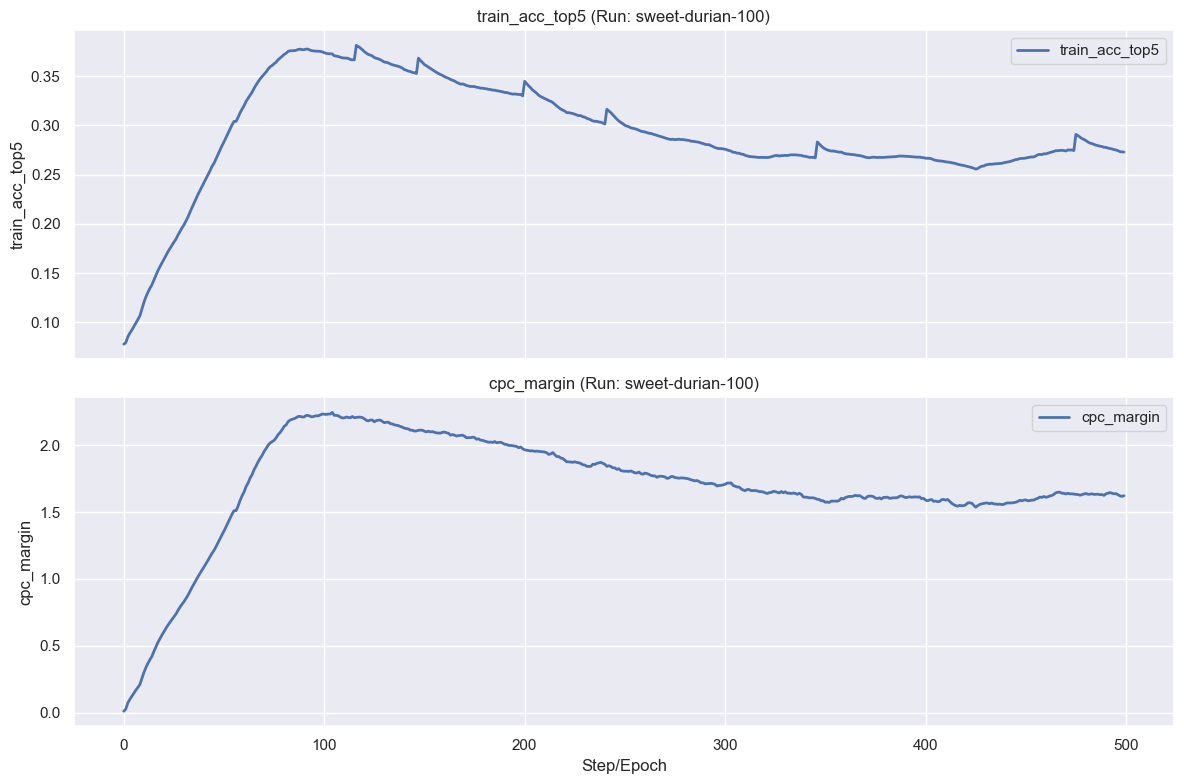

In [22]:
plotter.plot_run_metrics(run_id, metrics=["train_acc_top5", "cpc_margin"], smooth=0.9)

### 1.3 SNN Activity
- **Spike Density**: The fraction of neurons firing. Ideally stable around 20-30% for sparse but active representations.

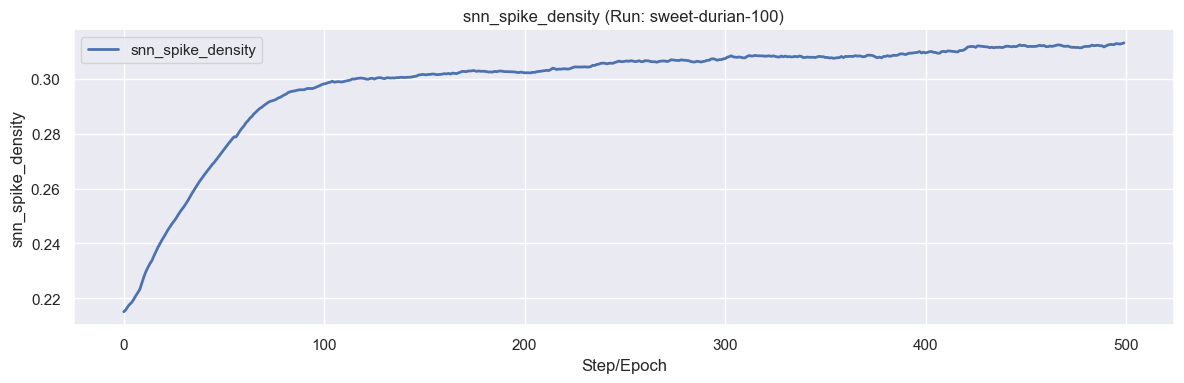

In [23]:
plotter.plot_run_metrics(run_id, metrics=["snn_spike_density"], smooth=0.9)

## 2. Gold Standard Evaluation (ROC/AUC)
Evaluating the model's ability to detect anomalies (signals) vs background noise using the contrastive loss as an anomaly score.

In [24]:
# Load Model Checkpoint
checkpoint_path = "/Users/gracjanziemianski/Documents/CPC-SNN-GravitationalWavesDetection/src/train/checkpoints/20251202-004211/latest.pt   "

print(f"Loading checkpoint from: {checkpoint_path}")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['config']

model = CPCSNN(
    in_channels=2,
    hidden_dim=config['hidden_dim'],
    context_dim=config['context_dim'],
    prediction_steps=config['prediction_steps'],
    delta_threshold=config['delta_threshold']
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Model loaded (Epoch {checkpoint['epoch']})")

Loading checkpoint from: /Users/gracjanziemianski/Documents/CPC-SNN-GravitationalWavesDetection/src/train/checkpoints/20251202-004211/latest.pt
Model loaded (Epoch 100)


In [25]:
from src.evaluation.evaluate_anomaly import compute_anomaly_score
from sklearn.metrics import roc_curve, auc

# Load Data Indices
noise_path = os.path.join(project_root, "data/indices_noise.json")
signal_path = os.path.join(project_root, "data/indices_signal.json")
h5_path = os.path.join(project_root, "data/cpc_snn_train.h5")

with open(noise_path, 'r') as f: noise_ids = json.load(f)
with open(signal_path, 'r') as f: signal_ids = json.load(f)

# Evaluate on subset
n_eval = 200 # Adjust for speed
test_ids = noise_ids[:n_eval] + signal_ids[:n_eval]
true_labels = [0]*n_eval + [1]*n_eval

dataset = HDF5SFTPairDataset(
    h5_path=h5_path,
    index_list=test_ids,
    return_time_series=True # We need raw data for inference if model expects it, or SFT if not.
    # Note: evaluate_anomaly.py uses return_time_series=True but CPCSNN expects SFT usually?
    # Let's check evaluate_anomaly.py again. It passes 'x' to model.
    # If model expects SFT, we need to ensure dataset returns it or we compute it.
    # HDF5SFTPairDataset returns 'x' as SFT if return_time_series=False (default).
    # If return_time_series=True, it might return raw strain.
    # Let's stick to what evaluate_anomaly.py does, assuming it's correct or fix it.
    # Wait, evaluate_anomaly.py sets return_time_series=True.
    # But CPCSNN forward expects (B, C, F, T) or similar SFT.
    # Let's check HDF5SFTPairDataset implementation if needed.
    # For now, let's use return_time_series=False to get SFT which CPCSNN definitely needs.
)

# Override dataset to return SFT for CPCSNN
dataset = HDF5SFTPairDataset(
    h5_path=h5_path,
    index_list=test_ids,
    return_time_series=False # Get SFT maps
)

loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

all_scores = []
print("Running Inference...")
with torch.no_grad():
    for batch in tqdm(loader):
        # Reconstruct if needed (dataset returns compressed)
        x = HDF5SFTPairDataset.batch_reconstruct_torch(batch, device=device)

        # Normalize
        mean = x.mean(dim=2, keepdim=True)
        std = x.std(dim=2, keepdim=True)
        x = (x - mean) / (std + 1e-8)

        scores = compute_anomaly_score(model, x, device)
        all_scores.extend(scores.cpu().numpy())

Running Inference...


100%|██████████| 13/13 [00:26<00:00,  2.05s/it]


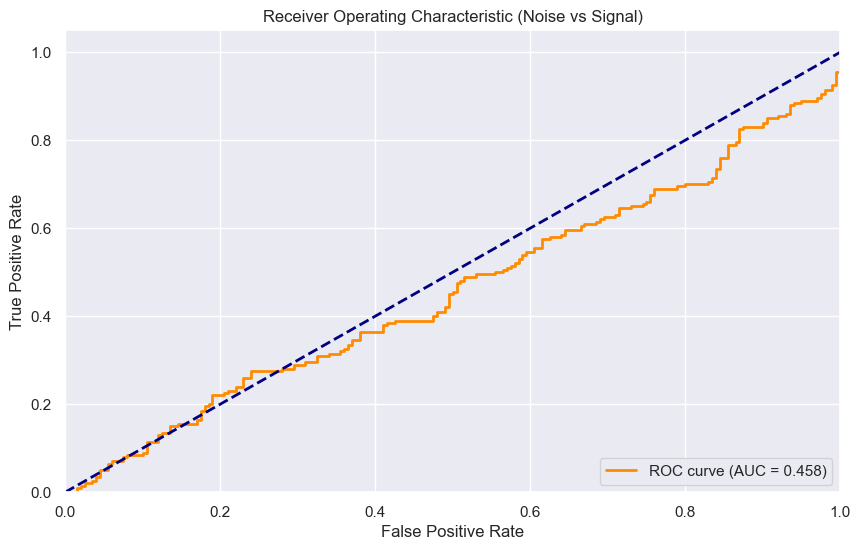

In [26]:
# Plot ROC
fpr, tpr, thresholds = roc_curve(true_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Noise vs Signal)')
plt.legend(loc="lower right")
plt.show()

## 3. Anomaly Score Visualization (Chirp vs Glitch)
Visualizing how the anomaly score (Contrastive Loss) evolves over time for a Gravitational Wave signal versus a Glitch/Noise sample.

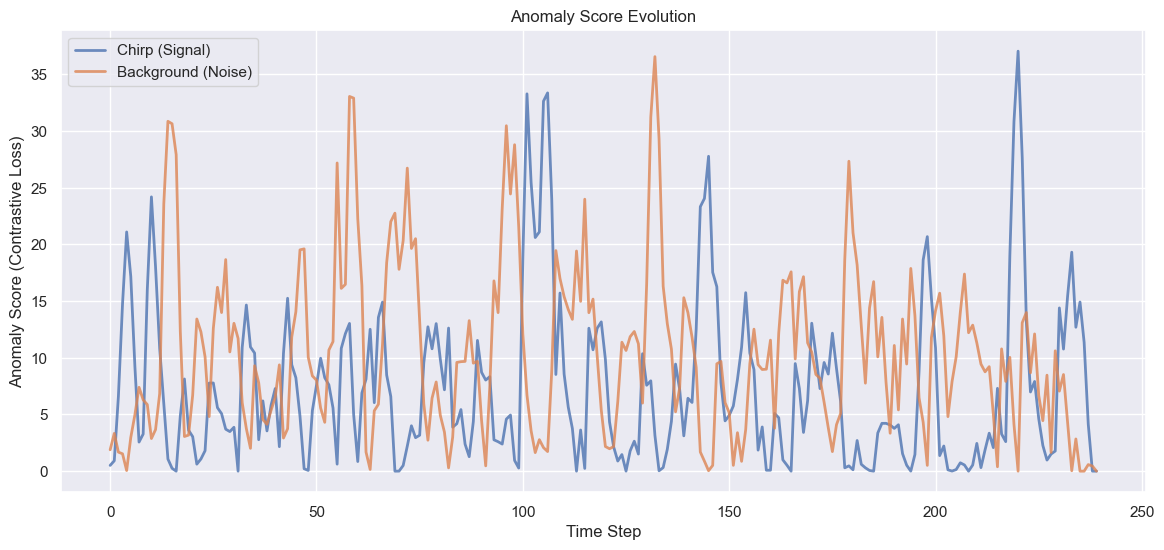

In [27]:
def get_anomaly_trace(model, x, device):
    model.eval()
    with torch.no_grad():
        z, c, _ = model(x)
        batch_size, time_steps, _ = z.shape
        
        # We want loss over time. 
        # CPC loss is computed for multiple future steps.
        # We can average the loss for each time step t across all k predictions that target t.
        # Or simpler: for each t, compute loss of predicting t+1, t+2... and assign to t.
        # Let's use the average loss contributed by step t as context.
        
        loss_over_time = torch.zeros(batch_size, time_steps).to(device)
        counts = torch.zeros(batch_size, time_steps).to(device)
        
        for k in range(1, model.prediction_steps + 1):
            if time_steps <= k: continue
            
            W_k = model.predictors[k-1]
            c_t = c[:, :-k, :] # Context at t
            z_tk = z[:, k:, :] # Target at t+k
            z_pred = W_k(c_t)
            
            # Logits
            logits = torch.einsum('bth, ath -> bta', z_pred, z_tk)
            labels = torch.arange(batch_size).to(device)
            labels = labels.unsqueeze(1).expand(batch_size, time_steps - k)
            
            # Loss at each step t
            loss_flat = torch.nn.functional.cross_entropy(
                logits.reshape(-1, batch_size), 
                labels.reshape(-1), 
                reduction='none'
            )
            loss_per_t = loss_flat.reshape(batch_size, time_steps - k)
            
            # Accumulate
            loss_over_time[:, :-k] += loss_per_t
            counts[:, :-k] += 1
            
        # Avoid div by zero
        counts[counts == 0] = 1
        return loss_over_time / counts

# Select samples
chirp_idx = signal_ids[0] # Assume first signal is a chirp
glitch_idx = noise_ids[0] # Assume first noise is background/glitch

sample_ids = [chirp_idx, glitch_idx]
sample_labels = ["Chirp (Signal)", "Background (Noise)"]

viz_dataset = HDF5SFTPairDataset(
    h5_path=h5_path,
    index_list=sample_ids,
    return_time_series=False
)
viz_loader = torch.utils.data.DataLoader(viz_dataset, batch_size=2, shuffle=False)

batch = next(iter(viz_loader))
x = HDF5SFTPairDataset.batch_reconstruct_torch(batch, device=device)
mean = x.mean(dim=2, keepdim=True)
std = x.std(dim=2, keepdim=True)
x = (x - mean) / (std + 1e-8)

traces = get_anomaly_trace(model, x, device).cpu().numpy()

# Plot
plt.figure(figsize=(14, 6))
for i, label in enumerate(sample_labels):
    plt.plot(traces[i], label=label, linewidth=2, alpha=0.8)

plt.xlabel("Time Step")
plt.ylabel("Anomaly Score (Contrastive Loss)")
plt.title("Anomaly Score Evolution")
plt.legend()
plt.show()

## 2. Anomaly Detection Evaluation (Inference)
Evaluating the model's ability to distinguish between background noise and gravitational wave signals using the anomaly score (contrastive loss).

In [28]:
from src.evaluation.evaluate_anomaly import compute_anomaly_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from torch.utils.data import DataLoader

# Load Model
checkpoint_path = "../checkpoints/20251130-230151/best.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

print(f"Loading model from {checkpoint_path}...")
checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['config']

model = CPCSNN(
    in_channels=2,
    hidden_dim=config['hidden_dim'],
    context_dim=config['context_dim'],
    prediction_steps=config['prediction_steps'],
    delta_threshold=config['delta_threshold']
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Model loaded (Epoch {checkpoint['epoch']})")

# Load Data
h5_path = "../data/cpc_snn_train.h5"
noise_indices_path = "../data/indices_noise.json"
signal_indices_path = "../data/indices_signal.json"

with open(noise_indices_path, 'r') as f: noise_ids = json.load(f)
with open(signal_indices_path, 'r') as f: signal_ids = json.load(f)

# Use a balanced subset for evaluation
n_eval = 500
test_ids = noise_ids[:n_eval] + signal_ids[:n_eval]
true_labels = [0]*n_eval + [1]*n_eval # 0=Noise, 1=Signal

dataset = HDF5SFTPairDataset(
    h5_path=h5_path,
    index_list=test_ids,
    return_time_series=True
)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Compute Scores
all_scores = []
print("Computing anomaly scores...")
for batch in tqdm(loader):
    x = batch['x'].to(device)
    scores = compute_anomaly_score(model, x, device)
    all_scores.extend(scores.cpu().numpy())

all_scores = np.array(all_scores)
true_labels = np.array(true_labels)

Loading model from ../checkpoints/20251130-230151/best.pt...
Model loaded (Epoch 100)
Computing anomaly scores...


  0%|          | 0/32 [00:00<?, ?it/s]/Users/gracjanziemianski/Documents/CPC-SNN-GravitationalWavesDetection/src/data_handling/torch_dataset.py:118: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, x_rec = istft(
100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


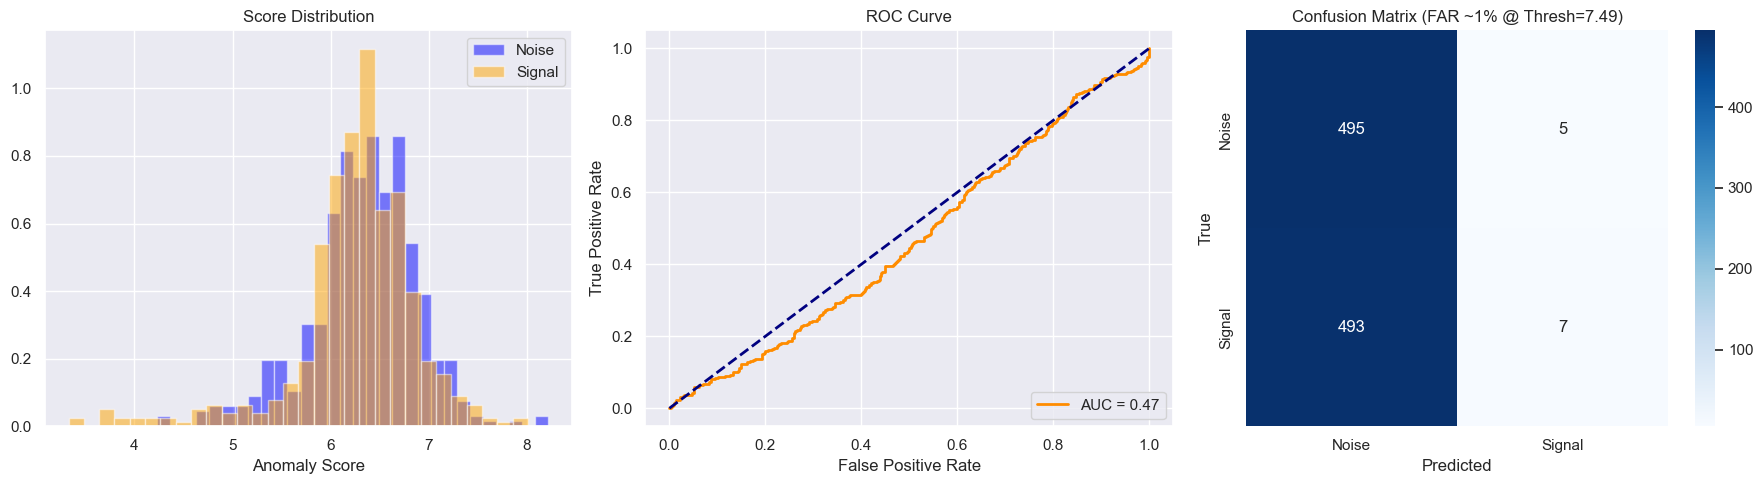

In [29]:
# Visualizations
fpr, tpr, thresholds = roc_curve(true_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(18, 5))

# 1. Histogram
plt.subplot(1, 3, 1)
plt.hist(all_scores[true_labels==0], bins=30, alpha=0.5, label='Noise', density=True, color='blue')
plt.hist(all_scores[true_labels==1], bins=30, alpha=0.5, label='Signal', density=True, color='orange')
plt.xlabel('Anomaly Score')
plt.title('Score Distribution')
plt.legend()

# 2. ROC Curve
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# 3. Confusion Matrix (at 1% FAR)
# Find threshold for 1% FAR (FPR <= 0.01)
idx_1pct = np.where(fpr <= 0.01)[0][-1]
threshold_1pct = thresholds[idx_1pct]

pred_labels = (all_scores >= threshold_1pct).astype(int)
cm = confusion_matrix(true_labels, pred_labels)

plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Noise', 'Signal'], yticklabels=['Noise', 'Signal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (FAR ~1% @ Thresh={threshold_1pct:.2f})')

plt.tight_layout()
plt.show()

## 3. Case Studies (Analiza Przypadków)
Visualizing specific examples to understand model behavior.
- **Pure Noise**: Should have low, flat score.
- **Glitch/Anomaly**: Noise with high score.
- **Gravitational Wave**: Signal with characteristic score pattern.

In [30]:
def plot_case_study(model, dataset, idx, title, device):
    data = dataset[idx]
    if isinstance(data, dict):
        x = data['x']
    else:
        x, _ = data
    x = x.unsqueeze(0).to(device) # (1, 2, T)
    
    model.eval()
    with torch.no_grad():
        z, c, _ = model(x)
        batch_size, time_steps, _ = z.shape
        total_loss = torch.zeros(batch_size, time_steps).to(device)
        counts = torch.zeros(batch_size, time_steps).to(device)
        
        for k in range(1, model.prediction_steps + 1):
            if time_steps <= k: continue
            W_k = model.predictors[k-1]
            c_t = c[:, :-k, :]
            z_tk = z[:, k:, :]
            z_pred = W_k(c_t)
            logits = torch.einsum('bth, ath -> bta', z_pred, z_tk)
            labels = torch.arange(batch_size).to(device).unsqueeze(1).expand(batch_size, time_steps - k)
            loss = torch.nn.functional.cross_entropy(logits.reshape(-1, batch_size), labels.reshape(-1), reduction='none')
            loss = loss.reshape(batch_size, time_steps - k)
            
            # Attribute loss to the target time step t+k
            total_loss[:, k:] += loss
            counts[:, k:] += 1
            
        counts[counts == 0] = 1
        score_trace = (total_loss / counts).cpu().numpy()[0]

    # Plot
    strain = x.cpu().numpy()[0, 0, :] # H1 strain
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    
    ax1.plot(strain, color='black', alpha=0.7)
    ax1.set_ylabel('Strain (Standardized)')
    ax1.set_title(f'{title} - Input Signal')
    
    ax2.plot(score_trace, color='red')
    ax2.set_ylabel('Anomaly Score')
    ax2.set_xlabel('Time Steps')
    ax2.set_title('Anomaly Score over Time')
    
    plt.show()

# Select Examples
# 1. Pure Noise: Lowest score in Noise set
noise_indices = np.where(true_labels == 0)[0]
idx_pure_noise = test_ids[noise_indices[np.argmin(all_scores[noise_indices])]]

# 2. Glitch: Highest score in Noise set (False Positive)
idx_glitch = test_ids[noise_indices[np.argmax(all_scores[noise_indices])]]

# 3. Gravitational Wave: Random Signal sample
signal_indices = np.where(true_labels == 1)[0]
idx_gw = test_ids[signal_indices[0]]

print(f"Plotting Case Studies...")
plot_case_study(model, dataset, dataset.ids.index(str(idx_pure_noise)), "Pure Noise", device)
plot_case_study(model, dataset, dataset.ids.index(str(idx_glitch)), "Glitch / Loud Noise", device)
plot_case_study(model, dataset, dataset.ids.index(str(idx_gw)), "Gravitational Wave", device)

Plotting Case Studies...


/Users/gracjanziemianski/Documents/CPC-SNN-GravitationalWavesDetection/src/data_handling/torch_dataset.py:118: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, x_rec = istft(


NameError: name 'F' is not defined